# Wasserstein Generative Adversarial Networks with Gradient Penalty
base on https://github.com/farizrahman4u/keras-contrib/pull/75/files/ead51c6a53e088374d0b57f939c7eb0a74b580c8

In [1]:
import os
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras import backend as K
from keras.utils.generic_utils import Progbar
from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from PIL import Image

Using TensorFlow backend.


## Total Loss  = Wasserstein Loss + Gradient Penalty Loss

## Wasserstein Loss
$$\mathbb{E}_{x\sim\mathbb{P}_r}[D(x)]-\mathbb{E}_{x\sim\mathbb{P}_g}[D(\tilde{x})]$$

$$\mathbb{E}_{x\sim\mathbb{P}_r}[D(x)]$$

In [2]:
def wasserstein_real_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

$$\mathbb{E}_{x\sim\mathbb{P}_g}[D(\tilde{x})]$$

In [3]:
def wasserstein_fake_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

## Gradient Penalty Loss
$$\lambda\mathbb{E}_{\hat{x}\sim\mathbb{P}_\hat{x}}[(\lVert\nabla_{\hat{x}}D(\hat{x})\rVert_2-1)^2]$$

In [4]:
lamda = 10
def gradient_penalty_loss(y_true, y_pred):
    averaged_samples_loss = K.mean(y_pred)
    gradients = K.gradients(averaged_samples_loss, trainable_weights)
    gradients = K.concatenate([K.flatten(tensor) for tensor in gradients])
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients)))
    gradient_penalty = 2 * lamda * K.square(1 - gradient_l2_norm)
    return gradient_penalty

## Build Generator

In [5]:
G_Input          = Input(shape=(100,))
G_Dense_1        = Dense(1024, activation=LeakyReLU())(G_Input)
G_Dense_2        = Dense(128*7*7, activation=LeakyReLU())(G_Dense_1)
G_Dense_2_BN     = BatchNormalization()(G_Dense_2)
G_Reshape        = Reshape((7,7,128))(G_Dense_2_BN)
G_ConvTrans_1    = Conv2DTranspose(128, (5, 5), strides=2, activation=LeakyReLU(), padding='same')(G_Reshape)
G_ConvTrans_1_BN = BatchNormalization()(G_ConvTrans_1)
G_ConvTrans_2    = Conv2DTranspose(64, (5, 5), activation=LeakyReLU(), padding='same')(G_ConvTrans_1_BN)
G_ConvTrans_2_BN = BatchNormalization()(G_ConvTrans_2)
G_ConvTrans_3    = Conv2DTranspose(64, (5, 5), strides=2, activation=LeakyReLU(), padding='same')(G_ConvTrans_2_BN)
G_ConvTrans_3_BN = BatchNormalization()(G_ConvTrans_3)
G_ConvTrans_4    = Conv2DTranspose(1, (5, 5), activation='tanh', padding='same')(G_ConvTrans_3_BN)

generator = Model(G_Input, G_ConvTrans_4, name='Generator')
print('Generator')
generator.summary()

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       


## Build Discriminator

In [6]:
D_input   = Input(shape=((28,28,1)))
D_Conv_1  = Convolution2D(64, (5, 5), padding='same', activation=LeakyReLU())(D_input)
D_Conv_2  = Convolution2D(128, (5, 5), kernel_initializer='he_normal', strides=2, activation=LeakyReLU())(D_Conv_1)
D_Conv_3  = Convolution2D(128, (5, 5), kernel_initializer='he_normal', strides=2, padding='same',activation=LeakyReLU())(D_Conv_2)
D_Flatten = Flatten()(D_Conv_3)
D_Dense_1 = Dense(1024, kernel_initializer='he_normal', activation=LeakyReLU())(D_Flatten)
D_Dense_2 = Dense(1, kernel_initializer='he_normal')(D_Dense_1)

discriminator = Model(D_input, D_Dense_2, name='Discriminator')
print('Discriminator')
discriminator.summary()

Discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         409728    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025   

## Loading MNIST

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.concatenate((X_train, X_test), axis=0)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train.shape

(70000, 28, 28, 1)

# Setting Trainable and Compile the Model

### Set discriminator be untrainable before the model for training generator is compiled
So discriminator will not to change weight when we are training generator

In [8]:
for layer in discriminator.layers:
    print(layer.trainable)

False
True
True
True
True
True
True


In [9]:
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

In [10]:
for layer in discriminator.layers:
    print(layer.trainable)

False
False
False
False
False
False
False


### Combine the model for training generator

In [11]:
Noise_input_for_training_generator = Input(shape=(100,))
Generated_image                    = generator(Noise_input_for_training_generator)
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model(Noise_input_for_training_generator, Discriminator_output)
print("model_for_training_generator")
model_for_training_generator.summary()

model_for_training_generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 28, 28, 1)         7276993   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 5336961   
Total params: 12,613,954
Trainable params: 7,263,937
Non-trainable params: 5,350,017
_________________________________________________________________


### Compile it

In [12]:
model_for_training_generator.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_real_loss)

### Same for generator, set generator be untrainable before the model for training discriminator is compiled
So generator will not to change weight when we are training discriminator

In [13]:
for layer in generator.layers:
    print(layer.trainable)

False
True
True
True
True
True
True
True
True
True
True
True


In [14]:
for layer in discriminator.layers:
    print(layer.trainable)

False
False
False
False
False
False
False


In [15]:
for layer in discriminator.layers:
    layer.trainable = True
discriminator.trainable = True
for layer in generator.layers:
    layer.trainable = False
generator.trainable = False

In [16]:
for layer in generator.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False


In [17]:
for layer in discriminator.layers:
    print(layer.trainable)

True
True
True
True
True
True
True


### Combine the model for training discriminator

In [18]:
Real_mnist                             = Input(shape=(28,28,1))
Noise_input_for_training_discriminator = Input(shape=(100,))
Fake_mnist                             = generator(Noise_input_for_training_discriminator)
Discriminator_output_for_real          = discriminator(Real_mnist)
Discriminator_output_for_fake          = discriminator(Fake_mnist)

model_for_training_discriminator       = Model([Real_mnist,
                                                Noise_input_for_training_discriminator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
model_for_training_discriminator.summary()

model_for_training_discriminator
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
Generator (Model)                (None, 28, 28, 1)     7276993                                      
____________________________________________________________________________________________________
Discriminator (Model)            (None, 1)             5336961                                      
Total params: 12,613,954
Trainable params: 5,336,961
Non-t

# WAIT?! WHERE IS GRADIENT PENALTY LOSS

### Generate sample for gadient penalty loss

#### Some Setting

In [19]:
batch_size = 64
training_ratio = 5

### Make the gadient pnalty loss input

In [20]:
class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [21]:
GP_mnist  = RandomWeightedAverage()([Real_mnist, Fake_mnist])
GP_output = discriminator(GP_mnist)

In [22]:
trainable_weights = discriminator.trainable_weights

In [23]:
model_for_training_discriminator = Model(inputs=[Real_mnist, Noise_input_for_training_discriminator],
                                         outputs=[Discriminator_output_for_real,
                                                  Discriminator_output_for_fake,
                                                  GP_output])
model_for_training_discriminator.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                                         loss=[wasserstein_real_loss,
                                               wasserstein_fake_loss,
                                               gradient_penalty_loss])

In [24]:
real_y = np.ones((batch_size, 1), dtype=np.float32)
fake_y = -real_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

In [25]:
epochs = 1

In [26]:
test_noise = np.random.rand(70000, 100).astype(np.float32)
test_real_y = np.ones((70000, 1), dtype=np.float32)
test_fake_y = -test_real_y
test_dummy_y = np.zeros((70000, 1), dtype=np.float32)
X_test = X_train
W_loss = []
test_noise_one = np.random.rand(1, 100)

In [27]:
for epoch in range(epochs):
    np.random.shuffle(X_train)
    
    print("epoch {} of {}".format(epoch+1, epochs))
    num_batches = int(X_train.shape[0] // batch_size)
    
    print("number of batches: {}".format(int(X_train.shape[0] // (batch_size))))
    
    progress_bar = Progbar(target=int(X_train.shape[0] // (batch_size * training_ratio)))
    discriminator_loss = []
    generator_loss = []
    minibatches_size = batch_size * training_ratio
    
    for index in range(int(X_train.shape[0] // (batch_size * training_ratio))):
        progress_bar.update(index)
        discriminator_minibatches = X_train[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(training_ratio):
            image_batch = discriminator_minibatches[j * batch_size : (j + 1) * batch_size]
            noise = np.random.rand(batch_size, 100).astype(np.float32)
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, noise],
                                                                                      [real_y, fake_y, dummy_y]))
        generator_loss.append(model_for_training_generator.train_on_batch(np.random.rand(batch_size, 100), real_y))
        
    W_real = model_for_training_generator.evaluate(test_noise, test_real_y)
    print(W_real)
    W_fake = model_for_training_generator.evaluate(test_noise, test_fake_y)
    print(W_fake)
    W_l = W_real-W_fake
    print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    ###################pickle.dump(W_loss,open('wloss-history.pkl', 'wb'))
    genrator_image = generator.predict(test_noise_one)
    genrator_image = (genrator_image * 127.5) + 127.5
    genrator_image = np.round(genrator_image).astype(np.uint8).reshape(28, 28)
    genrator_image = Image.fromarray(genrator_image, mode='L')
    genrator_image.save('epoch_{}.png'.format(epoch))

epoch 1 of 1
number of batches: 1093
70000/70000 [==============================] - 44s      

In [4]:
%matplotlib inline

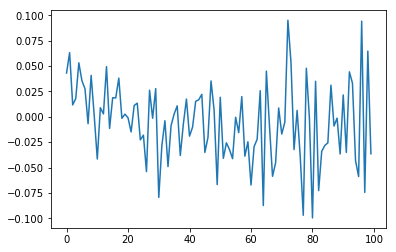

In [10]:
f = open('wloss-history.pkl', 'rb')
w_loss = pickle.load(f)
plt.plot(w_loss)